In [1]:
!pip install networkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 8.0 MB/s eta 0:00:00


In [2]:
!pip install powerlaw

In [3]:
import pandas as pd
import networkx as nx
import networkit as nk

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## by Disciplines

In [5]:
# Load the data from the file
file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_disciplines_entropy.xlsx'
df = pd.read_excel(file_path)

# Affiliation_disciplines is in a list format
df['affiliation_disciplines'] = df['affiliation_departments'].apply(eval)

# Create an edgelist
edgelist = []
for index, row in df.iterrows():
    title = row['title']
    disciplines = row['affiliation_disciplines']
    for discipline in disciplines:
        edgelist.append((title, discipline))

# Convert the edgelist to a DataFrame
edgelist_df = pd.DataFrame(edgelist, columns=['source', 'target'])

# Save the edgelist to a CSV file
edgelist_df.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_disciplines_entropy_edgelist.csv', index=False)

print("Edgelist created and saved as 'edgelist.csv'.")

Edgelist created and saved as 'edgelist.csv'.


In [6]:
# Map nodes to indices
node_map = {}
index = 0

def get_node_index(node):
    global index
    if node not in node_map:
        node_map[node] = index
        index += 1
    return node_map[node]

# Determine the number of unique nodes
num_nodes = len(set(edgelist_df['source']).union(set(edgelist_df['target'])))

# Create a bipartite graph with the predefined number of nodes
B = nk.graph.Graph(num_nodes, weighted=True, directed=False)

# Add edges to the bipartite graph
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    discipline = get_node_index(row['target'])
    B.addEdge(paper, discipline)

In [7]:
### Create weighted projected graph

# Collect disciplines
disciplines = set()
for _, row in edgelist_df.iterrows():
    disciplines.add(row['target'])

# Create a projection onto disciplines
projected_graph = nk.graph.Graph(len(disciplines), weighted=True, directed=False)

# Map disciplines to indices in the projected graph
discipline_map = {disc: i for i, disc in enumerate(disciplines)}

# Initialize a dictionary to hold the edge weights
edge_weights = {}

# Add edges between disciplines that share at least one paper, with weights
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    discipline = discipline_map[row['target']]
    for neighbor in B.iterNeighbors(paper):
        neighbor_discipline = None
        for key, value in node_map.items():
            if value == neighbor:
                if key in disciplines:
                    neighbor_discipline = discipline_map[key]
                    break
        if neighbor_discipline is not None and neighbor_discipline != discipline:
            if (discipline, neighbor_discipline) in edge_weights:
                edge_weights[(discipline, neighbor_discipline)] += 1
            elif (neighbor_discipline, discipline) in edge_weights:
                edge_weights[(neighbor_discipline, discipline)] += 1
            else:
                edge_weights[(discipline, neighbor_discipline)] = 1

# Add edges with weights to the projected graph
for (u, v), weight in edge_weights.items():
    projected_graph.addEdge(u, v, weight)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


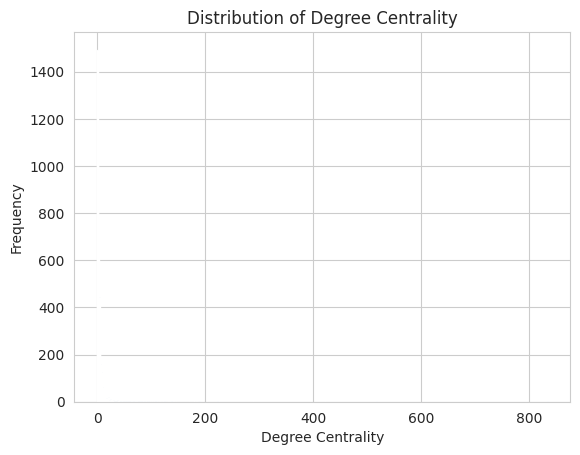

Degree Centrality: [(856, 835.0), (5996, 518.0), (6248, 422.0), (3814, 289.0), (3556, 226.0), (1954, 223.0), (4602, 204.0), (4534, 196.0), (5598, 190.0), (5905, 190.0)]
Closeness Centrality: [(89, 0.5), (1076, 0.5), (125, 0.5), (3422, 0.5), (147, 0.5), (3390, 0.5), (5738, 0.5), (170, 0.5), (509, 0.5), (6498, 0.5)]
Betweenness Centrality: [(856, 0.08876706467107558), (6248, 0.03765408065312015), (5996, 0.03514842431715771), (4602, 0.033812629693229256), (3556, 0.03350521934763619), (3814, 0.030160828395166078), (4534, 0.024916590893126866), (5904, 0.023048993570624548), (1954, 0.02159079041152156), (3531, 0.021564454292477966)]
Eigenvector Centrality: [(3306, 0.4460766697800469), (856, 0.4044578022023634), (5996, 0.37643240973702585), (1698, 0.29954560538935315), (2857, 0.2551303078817581), (6248, 0.2014788914090287), (1954, 0.13603714108733847), (5904, 0.12784525092887108), (842, 0.12763268210103978), (3814, 0.12296163352992957)]
Number of Nodes: 6604
Number of Edges: 16811
Density: 0.

In [8]:
import networkit as nk
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import powerlaw
import matplotlib.pyplot as plt

# Convert Networkit graph to NetworkX graph
def networkit_to_networkx(nk_graph):
    nx_graph = nx.Graph()
    for u in nk_graph.iterNodes():
        nx_graph.add_node(u)
    for u, v in nk_graph.iterEdges():
        nx_graph.add_edge(u, v, weight=nk_graph.weight(u, v))
    return nx_graph

# Create projected graph
projected_graph = nk.graph.Graph(len(disciplines), weighted=True, directed=False)
for (u, v), weight in edge_weights.items():
    projected_graph.addEdge(u, v, weight)

# Convert projected graph to NetworkX graph
nx_projected_graph = networkit_to_networkx(projected_graph)

# Calculate degree centrality (considering weights)
deg_centrality = nk.centrality.DegreeCentrality(projected_graph, ignoreSelfLoops=True)
deg_centrality.run()
degree_centrality_result = deg_centrality.ranking()

# Calculate closeness centrality for each connected component
components = nk.components.ConnectedComponents(projected_graph).run()
closeness_centrality_result = []

for component in components.getComponents():
    subgraph = nk.graphtools.subgraphFromNodes(projected_graph, component)
    closeness_centrality = nk.centrality.Closeness(subgraph, True, subgraph.upperNodeIdBound())
    closeness_centrality.run()
    closeness_centrality_result.extend(closeness_centrality.ranking())

# Sort the combined results
closeness_centrality_result.sort(key=lambda x: x[1], reverse=True)

# Calculate betweenness centrality
betweenness_centrality = nk.centrality.Betweenness(projected_graph, normalized=True)
betweenness_centrality.run()
betweenness_centrality_result = betweenness_centrality.ranking()

# Calculate eigenvector centrality
eigenvector_centrality = nk.centrality.EigenvectorCentrality(projected_graph)
eigenvector_centrality.run()
eigenvector_centrality_result = eigenvector_centrality.ranking()

# Summarize the network
num_nodes = projected_graph.numberOfNodes()
num_edges = projected_graph.numberOfEdges()
density = nk.graphtools.density(projected_graph)

# Extract largest connected component
largest_component = nk.components.ConnectedComponents.extractLargestConnectedComponent(projected_graph, True)

# Calculate diameter of the largest component
diam = nk.distance.Diameter(largest_component, algo=1)
diam.run()
diameter = diam.getDiameter()

# Calculate average shortest path length for the largest component
apsp = nk.distance.APSP(largest_component).run()
distances = apsp.getDistances()

total_distance = 0
total_pairs = 0

for row in distances:
    for dist in row:
        if dist < float('inf'):
            total_distance += dist
            total_pairs += 1

avg_shortest_path_length = total_distance / total_pairs if total_pairs > 0 else float('inf')

# Calculate clustering coefficient
clustering_coefficient_result = nk.globals.clustering(projected_graph)

num_components = components.numberOfComponents()
largest_component_size = largest_component.numberOfNodes()

# Calculate the degree distribution
dc = nk.centrality.DegreeCentrality(projected_graph)
dc.run()
scores = dc.scores()

# Fit the degree distribution to a power law using the powerlaw package
fit = powerlaw.Fit(scores)
power_law_value = fit.power_law.alpha

# Plot the degree distribution (optional)
degree_counts = {}
for score in scores:
    if score in degree_counts:
        degree_counts[score] += 1
    else:
        degree_counts[score] = 1

plt.bar(degree_counts.keys(), degree_counts.values())
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()

# Community detection using Clauset-Newman-Moore in NetworkX
communities = greedy_modularity_communities(nx_projected_graph)
num_communities_nx = len(communities)

# Community detection using PLM in Networkit
community_detector = nk.community.PLM(projected_graph)
community_detector.run()
num_communities_nk = len(community_detector.getPartition().getSubsetIds())

# Print results
print("Degree Centrality:", degree_centrality_result[:10])  # Top 10 nodes
print("Closeness Centrality:", closeness_centrality_result[:10])  # Top 10 nodes
print("Betweenness Centrality:", betweenness_centrality_result[:10])  # Top 10 nodes
print("Eigenvector Centrality:", eigenvector_centrality_result[:10])  # Top 10 nodes

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Density:", density)
print("Diameter of Largest Component:", diameter)
print("Average Shortest Path Length:", avg_shortest_path_length)
print("Clustering Coefficient:", clustering_coefficient_result)
print("Number of Components:", num_components)
print("Size of Largest Component:", largest_component_size)
print("Power-law Exponent:", power_law_value)
print("Number of Communities (Networkit - PLM):", num_communities_nk)
print("Number of Communities (NetworkX - Clauset-Newman-Moore):", num_communities_nx)

# Optionally convert indices back to node names for centrality measures
reverse_discipline_map = {v: k for k, v in discipline_map.items()}
degree_centrality_named = [(reverse_discipline_map[node], centrality) for node, centrality in degree_centrality_result]
closeness_centrality_named = [(reverse_discipline_map[node], centrality) for node, centrality in closeness_centrality_result]
betweenness_centrality_named = [(reverse_discipline_map[node], centrality) for node, centrality in betweenness_centrality_result]
eigenvector_centrality_named = [(reverse_discipline_map[node], centrality) for node, centrality in eigenvector_centrality_result]

print("Degree Centrality (Named):", degree_centrality_named[:10])
print("Closeness Centrality (Named):", closeness_centrality_named[:10])
print("Betweenness Centrality (Named):", betweenness_centrality_named[:10])
print("Eigenvector Centrality (Named):", eigenvector_centrality_named[:10])


In [9]:
# Save the projected graph as a CSV file
edges = []
for u in range(projected_graph.numberOfNodes()):
    for v in projected_graph.iterNeighbors(u):
        weight = projected_graph.weight(u, v)
        edges.append([reverse_discipline_map[u], reverse_discipline_map[v], weight])

projected_disciplines_edgelist = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
projected_disciplines_edgelist.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/disciplines_projected_edgelist.csv', index=False)

print("Projected graph saved as 'projected_graph.csv'.")

Projected graph saved as 'projected_graph.csv'.


In [10]:
from collections import Counter

file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/disciplines_projected_edgelist.csv'
projected_df = pd.read_csv(file_path)

# Create a weighted graph from the dataframe
G = nx.from_pandas_edgelist(projected_df, 'source', 'target', ['weight'])

# List of nodes directly connected to Computer Science
CS_connected_nodes = list(G.neighbors('Computer Science'))
print('Disciplines connected to Computer Science:')
print(CS_connected_nodes)

# Analyze Computer Science as an intermediary
intermediary_connections = []

for node in CS_connected_nodes:
    for connected_node in G.neighbors(node):
        if connected_node != 'Computer Science' and connected_node not in CS_connected_nodes:
            weight = G[node][connected_node]['weight'] if 'weight' in G[node][connected_node] else 1
            intermediary_connections.append((node, connected_node, weight))

# Count frequency of intermediary connections considering weights
intermediary_counter = Counter()
for node, connected_node, weight in intermediary_connections:
    intermediary_counter[(node, connected_node)] += weight

# Prepare the data for the CSV file
intermediary_data = [{'Connection': f'{connection[0]} - {connection[1]}', 'Frequency': freq} for connection, freq in intermediary_counter.items()]

# Create a DataFrame and save to CSV
intermediary_df = pd.DataFrame(intermediary_data)
intermediary_df.to_csv('CS_intermediary_connections.csv', index=False)

Disciplines connected to Computer Science:
['Neurology', 'Geospatial Data Science', 'English', 'Computer Science & Information Engineering', 'Chemistry', 'Natural Language Processing', 'Chinese Information Processing', 'Scientific Research', 'Pathology and Immunology', 'Interaction', 'Chemical Technology', 'Electronic and Computer Engineering', 'Telecommunication Systems Management', 'AI Lab', 'Health Information', 'Natural Sciences', 'Social Science and Humanities', 'Economic Sciences', 'Electronic and Communications Engineering', 'Human Language Technology', 'Cognitive Science', 'Information and Physical Sciences', 'Finance & Economics', 'Advanced Research Computing', 'Information Technology Application Innovation', 'Information and Electronics', 'Computer Vision', 'Anesthesiology and Pain Medicine', 'General Surgery', 'Contents Research', 'Geography and Environment', 'Cultural Sciences', 'Prosthodontics', 'Bio-Med Big Data', 'Epidemiology and Population Health', 'Computing and Commu

In [11]:
from collections import Counter

file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/disciplines_projected_edgelist.csv'
projected_df = pd.read_csv(file_path)

# Create a weighted graph from the dataframe
G = nx.from_pandas_edgelist(projected_df, 'source', 'target', ['weight'])

# List of nodes directly connected to Medicine
MEDICINE_connected_nodes = list(G.neighbors('Medicine'))
print('Disciplines connected to Medicine:')
print(MEDICINE_connected_nodes)

# Analyze Medicine as an intermediary
intermediary_connections = []

for node in MEDICINE_connected_nodes:
    for connected_node in G.neighbors(node):
        if connected_node != 'Medicine' and connected_node not in MEDICINE_connected_nodes:
            weight = G[node][connected_node]['weight'] if 'weight' in G[node][connected_node] else 1
            intermediary_connections.append((node, connected_node, weight))

# Count frequency of intermediary connections considering weights
intermediary_counter = Counter()
for node, connected_node, weight in intermediary_connections:
    intermediary_counter[(node, connected_node)] += weight

# Prepare the data for the MEDICINEV file
intermediary_data = [{'Connection': f'{connection[0]} - {connection[1]}', 'Frequency': freq} for connection, freq in intermediary_counter.items()]

# Create a DataFrame and save to MEDICINEV
intermediary_df = pd.DataFrame(intermediary_data)
intermediary_df.to_csv('MEDICINE_intermediary_connections.csv', index=False)

Disciplines connected to Medicine:
['Neurology', 'Artificial Intelligence in Healthcare', 'Cognitive and Brain Sciences', 'Chemistry', 'Natural Language Processing', 'Pathology and Immunology', 'Behavioral Health and Technology', "Men's Health: Aging and Metabolism", 'Clinical Cell Therapy', 'Physiotherapy', 'Health Information', 'Health Care Policy and Research', 'Data-Driven Insights and Innovation', 'Anesthesiology and Pharmacology', 'Computational Precision Health', 'Math and Computer', 'Surgical Outcomes Research', 'General Surgery', 'Plastic surgeon', 'Epidemiology and Population Health', 'Epidemiology', 'Child and Adolescent Psychiatry', 'Health Research Methods', 'Future Studies', 'Applied Science', 'Public Health and Human Sciences', 'Industrial Engineering and Engineering Management', 'Human Performance, Health Informatics and Information Management', 'Biomedical Informatics Research', 'Biomedical', 'Otolaryngology-Head and Neck Surgery', 'Health Policy and Administration', '

In [ ]:
### calculate the intermediaries (the facilitators of LLMs research)

In [12]:
print(projected_graph.numberOfNodes(), projected_graph.numberOfEdges())

6604 16811


## by Countries

Edgelist created and saved as 'affiliation_countries_entropy_edgelist.csv'.


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


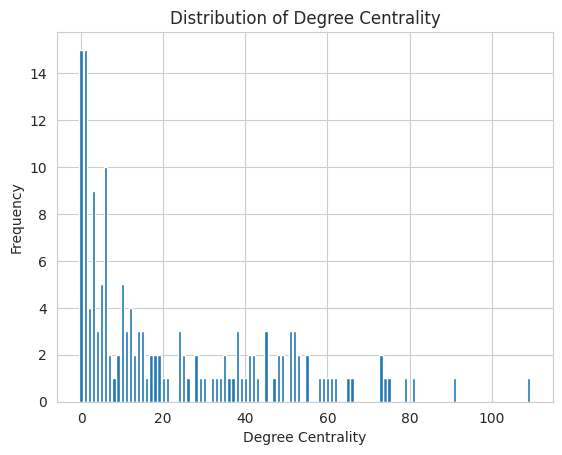

Degree Centrality: [(135, 109.0), (12, 91.0), (144, 81.0), (75, 79.0), (140, 75.0), (13, 74.0), (132, 73.0), (136, 73.0), (138, 66.0), (131, 65.0)]
Closeness Centrality: [(106, 0.15688487584650113), (63, 0.15653153153153154), (121, 0.15548098434004473), (79, 0.15444444444444444), (84, 0.15444444444444444), (67, 0.15376106194690264), (35, 0.15274725274725276), (41, 0.15274725274725276), (93, 0.1514161220043573), (27, 0.15075921908893708)]
Betweenness Centrality: [(67, 0.055920913371950334), (12, 0.05285666132797528), (140, 0.05065570106776354), (132, 0.05003247180240783), (79, 0.050017917461208254), (109, 0.04959332730625403), (135, 0.04885864646189507), (35, 0.039970029407069), (121, 0.039526543934011844), (106, 0.03731946099730979)]
Eigenvector Centrality: [(135, 0.6295445795473122), (144, 0.49794492756320247), (12, 0.3949531288151762), (75, 0.2217530053276675), (140, 0.19366943410962886), (136, 0.16945075702251808), (78, 0.13026776130242348), (131, 0.11542482204346712), (138, 0.08369

In [13]:
import pandas as pd
import networkit as nk
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import powerlaw
import matplotlib.pyplot as plt

# Load the data from the file
file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_countries_entropy.xlsx'  # Update this path to the correct file location
df = pd.read_excel(file_path)

# Ensure that affiliation_countries is in a list format
df['affiliation_countries'] = df['affiliation_countries'].apply(eval)

# Create an edgelist
edgelist = []
for index, row in df.iterrows():
    title = row['title']
    countries = row['affiliation_countries']
    for country in countries:
        edgelist.append((title, country))

# Convert the edgelist to a DataFrame
edgelist_df = pd.DataFrame(edgelist, columns=['source', 'target'])

# Save the edgelist to a CSV file
edgelist_df.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_countries_entropy_edgelist.csv', index=False)

print("Edgelist created and saved as 'affiliation_countries_entropy_edgelist.csv'.")

# Map nodes to indices
node_map = {}
index = 0

def get_node_index(node):
    global index
    if node not in node_map:
        node_map[node] = index
        index += 1
    return node_map[node]

# Determine the number of unique nodes
num_nodes = len(set(edgelist_df['source']).union(set(edgelist_df['target'])))

# Create a bipartite graph with the predefined number of nodes
B = nk.graph.Graph(num_nodes, weighted=True, directed=False)

# Add edges to the bipartite graph
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    country = get_node_index(row['target'])
    B.addEdge(paper, country)

# Collect countries
countries = set()
for _, row in edgelist_df.iterrows():
    countries.add(row['target'])

# Create a projection onto countries
projected_graph = nk.graph.Graph(len(countries), weighted=True, directed=False)

# Map countries to indices in the projected graph
country_map = {country: i for i, country in enumerate(countries)}

# Initialize a dictionary to hold the edge weights
edge_weights = {}

# Add edges between countries that share at least one paper, with weights
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    country = country_map[row['target']]
    for neighbor in B.iterNeighbors(paper):
        neighbor_country = None
        for key, value in node_map.items():
            if value == neighbor:
                if key in countries:
                    neighbor_country = country_map[key]
                    break
        if neighbor_country is not None and neighbor_country != country:
            if (country, neighbor_country) in edge_weights:
                edge_weights[(country, neighbor_country)] += 1
            elif (neighbor_country, country) in edge_weights:
                edge_weights[(neighbor_country, country)] += 1
            else:
                edge_weights[(country, neighbor_country)] = 1

# Add edges with weights to the projected graph
for (u, v), weight in edge_weights.items():
    projected_graph.addEdge(u, v, weight)

# Convert Networkit graph to NetworkX graph
def networkit_to_networkx(nk_graph):
    nx_graph = nx.Graph()
    for u in nk_graph.iterNodes():
        nx_graph.add_node(u)
    for u, v in nk_graph.iterEdges():
        nx_graph.add_edge(u, v, weight=nk_graph.weight(u, v))
    return nx_graph

# Convert projected graph to NetworkX graph
nx_projected_graph = networkit_to_networkx(projected_graph)

# Calculate degree centrality (considering weights)
deg_centrality = nk.centrality.DegreeCentrality(projected_graph, ignoreSelfLoops=True)
deg_centrality.run()
degree_centrality_result = deg_centrality.ranking()

# Calculate closeness centrality for each connected component
components = nk.components.ConnectedComponents(projected_graph).run()
closeness_centrality_result = []

for component in components.getComponents():
    subgraph = nk.graphtools.subgraphFromNodes(projected_graph, component)
    closeness_centrality = nk.centrality.Closeness(subgraph, True, subgraph.upperNodeIdBound())
    closeness_centrality.run()
    closeness_centrality_result.extend(closeness_centrality.ranking())

# Sort the combined results
closeness_centrality_result.sort(key=lambda x: x[1], reverse=True)

# Calculate betweenness centrality
betweenness_centrality = nk.centrality.Betweenness(projected_graph, normalized=True)
betweenness_centrality.run()
betweenness_centrality_result = betweenness_centrality.ranking()

# Calculate eigenvector centrality
eigenvector_centrality = nk.centrality.EigenvectorCentrality(projected_graph)
eigenvector_centrality.run()
eigenvector_centrality_result = eigenvector_centrality.ranking()

# Summarize the network
num_nodes = projected_graph.numberOfNodes()
num_edges = projected_graph.numberOfEdges()
density = nk.graphtools.density(projected_graph)

# Extract largest connected component
largest_component = nk.components.ConnectedComponents.extractLargestConnectedComponent(projected_graph, True)

# Calculate diameter of the largest component
diam = nk.distance.Diameter(largest_component, algo=1)
diam.run()
diameter = diam.getDiameter()

# Calculate average shortest path length for the largest component
apsp = nk.distance.APSP(largest_component).run()
distances = apsp.getDistances()

total_distance = 0
total_pairs = 0

for row in distances:
    for dist in row:
        if dist < float('inf'):
            total_distance += dist
            total_pairs += 1

avg_shortest_path_length = total_distance / total_pairs if total_pairs > 0 else float('inf')

# Calculate clustering coefficient
clustering_coefficient_result = nk.globals.clustering(projected_graph)

num_components = components.numberOfComponents()
largest_component_size = largest_component.numberOfNodes()

# Calculate the degree distribution
dc = nk.centrality.DegreeCentrality(projected_graph)
dc.run()
scores = dc.scores()

# Fit the degree distribution to a power law using the powerlaw package
fit = powerlaw.Fit(scores)
power_law_value = fit.power_law.alpha

# Plot the degree distribution (optional)
degree_counts = {}
for score in scores:
    if score in degree_counts:
        degree_counts[score] += 1
    else:
        degree_counts[score] = 1

plt.bar(degree_counts.keys(), degree_counts.values())
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()

# Community detection using Clauset-Newman-Moore in NetworkX
communities = greedy_modularity_communities(nx_projected_graph)
num_communities_nx = len(communities)

# Community detection using PLM in Networkit
community_detector = nk.community.PLM(projected_graph)
community_detector.run()
num_communities_nk = len(community_detector.getPartition().getSubsetIds())

# Print results
print("Degree Centrality:", degree_centrality_result[:10])  # Top 10 nodes
print("Closeness Centrality:", closeness_centrality_result[:10])  # Top 10 nodes
print("Betweenness Centrality:", betweenness_centrality_result[:10])  # Top 10 nodes
print("Eigenvector Centrality:", eigenvector_centrality_result[:10])  # Top 10 nodes

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Density:", density)
print("Diameter of Largest Component:", diameter)
print("Average Shortest Path Length:", avg_shortest_path_length)
print("Clustering Coefficient:", clustering_coefficient_result)
print("Number of Components:", num_components)
print("Size of Largest Component:", largest_component_size)
print("Power-law Exponent:", power_law_value)
print("Number of Communities (Networkit - PLM):", num_communities_nk)
print("Number of Communities (NetworkX - Clauset-Newman-Moore):", num_communities_nx)

# Optionally convert indices back to node names for centrality measures
reverse_country_map = {v: k for k, v in country_map.items()}
degree_centrality_named = [(reverse_country_map[node], centrality) for node, centrality in degree_centrality_result]
closeness_centrality_named = [(reverse_country_map[node], centrality) for node, centrality in closeness_centrality_result]
betweenness_centrality_named = [(reverse_country_map[node], centrality) for node, centrality in betweenness_centrality_result]
eigenvector_centrality_named = [(reverse_country_map[node], centrality) for node, centrality in eigenvector_centrality_result]

print("Degree Centrality (Named):", degree_centrality_named[:10])
print("Closeness Centrality (Named):", closeness_centrality_named[:10])
print("Betweenness Centrality (Named):", betweenness_centrality_named[:10])
print("Eigenvector Centrality (Named):", eigenvector_centrality_named[:10])

# Save the projected graph as a CSV file
edges = []
for u in range(projected_graph.numberOfNodes()):
    for v in projected_graph.iterNeighbors(u):
        weight = projected_graph.weight(u, v)
        edges.append([reverse_country_map[u], reverse_country_map[v], weight])

projected_countries_edgelist = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
projected_countries_edgelist.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/countries_projected_edgelist.csv', index=False)

print("Projected graph saved as 'countries_projected_edgelist.csv'.")


## by Institutions


Edgelist created and saved as 'edgelist.csv'.


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


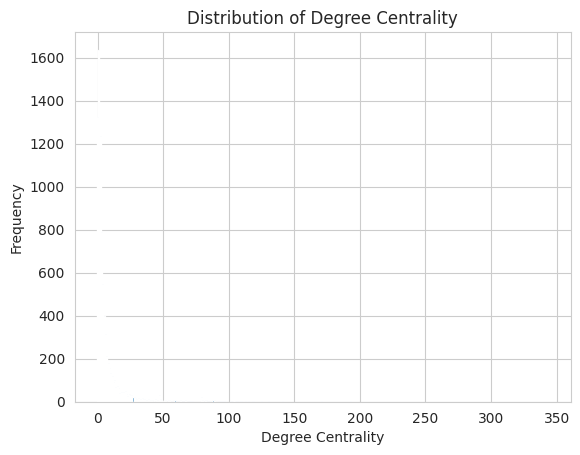

Degree Centrality: [(549, 343.0), (5107, 287.0), (2446, 262.0), (5789, 256.0), (750, 227.0), (7593, 217.0), (5263, 213.0), (7383, 212.0), (3571, 211.0), (320, 193.0)]
Closeness Centrality: [(4, 0.5), (2586, 0.5), (9, 0.5), (1285, 0.5), (2675, 0.5), (123, 0.5), (8139, 0.5), (205, 0.5), (687, 0.5), (5010, 0.5)]
Betweenness Centrality: [(2908, 0.02757507261750126), (5263, 0.026457276765840133), (549, 0.021443895439085828), (750, 0.02112526482823458), (5107, 0.02061087350081263), (2446, 0.01713821529943226), (7383, 0.016514624208122334), (3571, 0.016402542250148436), (7347, 0.01609770222885705), (2954, 0.015375209672710874)]
Eigenvector Centrality: [(6027, 0.6099005941386703), (6440, 0.5407950503079367), (8163, 0.36743011457695784), (424, 0.304526517774561), (2281, 0.1134043415872812), (7463, 0.08953984909935338), (6337, 0.08878342203067228), (405, 0.08847034114807593), (2858, 0.08823089619710711), (7255, 0.08751732399403461)]
Number of Nodes: 8391
Number of Edges: 35080
Density: 0.0009965

In [14]:
file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_institutions_entropy.xlsx'  # Update this path to the correct file location
df = pd.read_excel(file_path)

df['affiliation_institutions'] = df['affiliation_institutions'].apply(eval)

# Create an edgelist
edgelist = []
for index, row in df.iterrows():
    title = row['title']
    institutions = row['affiliation_institutions']
    for institution in institutions:
        edgelist.append((title, institution))

# Convert the edgelist to a DataFrame
edgelist_df = pd.DataFrame(edgelist, columns=['source', 'target'])

# Save the edgelist to a CSV file
edgelist_df.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/affiliation_institutions_entropy_edgelist.csv', index=False)

print("Edgelist created and saved as 'edgelist.csv'.")

# Map nodes to indices
node_map = {}
index = 0

def get_node_index(node):
    global index
    if node not in node_map:
        node_map[node] = index
        index += 1
    return node_map[node]

# Determine the number of unique nodes
num_nodes = len(set(edgelist_df['source']).union(set(edgelist_df['target'])))

# Create a bipartite graph with the predefined number of nodes
B = nk.graph.Graph(num_nodes, weighted=True, directed=False)

# Add edges to the bipartite graph
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    institution = get_node_index(row['target'])
    B.addEdge(paper, institution)

#Collect institutions
institutions = set()
for _, row in edgelist_df.iterrows():
    institutions.add(row['target'])

# Create a projection onto institutions
projected_graph = nk.graph.Graph(len(institutions), weighted=True, directed=False)

# Map institutions to indices in the projected graph
institution_map = {institution: i for i, institution in enumerate(institutions)}

# Initialize a dictionary to hold the edge weights
edge_weights = {}

# Add edges between institutions that share at least one paper, with weights
for _, row in edgelist_df.iterrows():
    paper = get_node_index(row['source'])
    institution = institution_map[row['target']]
    for neighbor in B.iterNeighbors(paper):
        neighbor_institution = None
        for key, value in node_map.items():
            if value == neighbor:
                if key in institutions:
                    neighbor_institution = institution_map[key]
                    break
        if neighbor_institution is not None and neighbor_institution != institution:
            if (institution, neighbor_institution) in edge_weights:
                edge_weights[(institution, neighbor_institution)] += 1
            elif (neighbor_institution, institution) in edge_weights:
                edge_weights[(neighbor_institution, institution)] += 1
            else:
                edge_weights[(institution, neighbor_institution)] = 1

# Add edges with weights to the projected graph
for (u, v), weight in edge_weights.items():
    projected_graph.addEdge(u, v, weight)

import networkit as nk
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import powerlaw
import matplotlib.pyplot as plt

# Convert Networkit graph to NetworkX graph
def networkit_to_networkx(nk_graph):
    nx_graph = nx.Graph()
    for u in nk_graph.iterNodes():
        nx_graph.add_node(u)
    for u, v in nk_graph.iterEdges():
        nx_graph.add_edge(u, v, weight=nk_graph.weight(u, v))
    return nx_graph

# Create projected graph
projected_graph = nk.graph.Graph(len(institutions), weighted=True, directed=False)
for (u, v), weight in edge_weights.items():
    projected_graph.addEdge(u, v, weight)

# Convert projected graph to NetworkX graph
nx_projected_graph = networkit_to_networkx(projected_graph)

# Calculate degree centrality (considering weights)
deg_centrality = nk.centrality.DegreeCentrality(projected_graph, ignoreSelfLoops=True)
deg_centrality.run()
degree_centrality_result = deg_centrality.ranking()

# Calculate closeness centrality for each connected component
components = nk.components.ConnectedComponents(projected_graph).run()
closeness_centrality_result = []

for component in components.getComponents():
    subgraph = nk.graphtools.subgraphFromNodes(projected_graph, component)
    closeness_centrality = nk.centrality.Closeness(subgraph, True, subgraph.upperNodeIdBound())
    closeness_centrality.run()
    closeness_centrality_result.extend(closeness_centrality.ranking())

# Sort the combined results
closeness_centrality_result.sort(key=lambda x: x[1], reverse=True)

# Calculate betweenness centrality
betweenness_centrality = nk.centrality.Betweenness(projected_graph, normalized=True)
betweenness_centrality.run()
betweenness_centrality_result = betweenness_centrality.ranking()

# Calculate eigenvector centrality
eigenvector_centrality = nk.centrality.EigenvectorCentrality(projected_graph)
eigenvector_centrality.run()
eigenvector_centrality_result = eigenvector_centrality.ranking()

# Summarize the network
num_nodes = projected_graph.numberOfNodes()
num_edges = projected_graph.numberOfEdges()
density = nk.graphtools.density(projected_graph)

# Extract largest connected component
largest_component = nk.components.ConnectedComponents.extractLargestConnectedComponent(projected_graph, True)

# Calculate diameter of the largest component
diam = nk.distance.Diameter(largest_component, algo=1)
diam.run()
diameter = diam.getDiameter()

# Calculate average shortest path length for the largest component
apsp = nk.distance.APSP(largest_component).run()
distances = apsp.getDistances()

total_distance = 0
total_pairs = 0

for row in distances:
    for dist in row:
        if dist < float('inf'):
            total_distance += dist
            total_pairs += 1

avg_shortest_path_length = total_distance / total_pairs if total_pairs > 0 else float('inf')

# Calculate clustering coefficient
clustering_coefficient_result = nk.globals.clustering(projected_graph)

num_components = components.numberOfComponents()
largest_component_size = largest_component.numberOfNodes()

# Calculate the degree distribution
dc = nk.centrality.DegreeCentrality(projected_graph)
dc.run()
scores = dc.scores()

# Fit the degree distribution to a power law using the powerlaw package
fit = powerlaw.Fit(scores)
power_law_value = fit.power_law.alpha

# Plot the degree distribution (optional)
degree_counts = {}
for score in scores:
    if score in degree_counts:
        degree_counts[score] += 1
    else:
        degree_counts[score] = 1

plt.bar(degree_counts.keys(), degree_counts.values())
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()

# Community detection using Clauset-Newman-Moore in NetworkX
communities = greedy_modularity_communities(nx_projected_graph)
num_communities_nx = len(communities)

# Community detection using PLM in Networkit
community_detector = nk.community.PLM(projected_graph)
community_detector.run()
num_communities_nk = len(community_detector.getPartition().getSubsetIds())

# Print results
print("Degree Centrality:", degree_centrality_result[:10])  # Top 10 nodes
print("Closeness Centrality:", closeness_centrality_result[:10])  # Top 10 nodes
print("Betweenness Centrality:", betweenness_centrality_result[:10])  # Top 10 nodes
print("Eigenvector Centrality:", eigenvector_centrality_result[:10])  # Top 10 nodes

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Density:", density)
print("Diameter of Largest Component:", diameter)
print("Average Shortest Path Length:", avg_shortest_path_length)
print("Clustering Coefficient:", clustering_coefficient_result)
print("Number of Components:", num_components)
print("Size of Largest Component:", largest_component_size)
print("Power-law Exponent:", power_law_value)
print("Number of Communities (Networkit - PLM):", num_communities_nk)
print("Number of Communities (NetworkX - Clauset-Newman-Moore):", num_communities_nx)

# Convert indices back to node names for centrality measures
reverse_institution_map = {v: k for k, v in institution_map.items()}
degree_centrality_named = [(reverse_institution_map[node], centrality) for node, centrality in degree_centrality_result]
closeness_centrality_named = [(reverse_institution_map[node], centrality) for node, centrality in closeness_centrality_result]
betweenness_centrality_named = [(reverse_institution_map[node], centrality) for node, centrality in betweenness_centrality_result]
eigenvector_centrality_named = [(reverse_institution_map[node], centrality) for node, centrality in eigenvector_centrality_result]

print("Degree Centrality (Named):", degree_centrality_named[:10])
print("Closeness Centrality (Named):", closeness_centrality_named[:10])
print("Betweenness Centrality (Named):", betweenness_centrality_named[:10])
print("Eigenvector Centrality (Named):", eigenvector_centrality_named[:10])

# Save the projected graph as a CSV file
reverse_institution_map = {v: k for k, v in institution_map.items()}
edges = []
for u in range(projected_graph.numberOfNodes()):
    for v in projected_graph.iterNeighbors(u):
        weight = projected_graph.weight(u, v)
        edges.append([reverse_institution_map[u], reverse_institution_map[v], weight])

projected_institutions_edgelist = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
projected_institutions_edgelist.to_csv('/content/drive/MyDrive/Project - LLM science of science/data_network/institutions_projected_edgelist.csv', index=False)

print("Projected graph saved as 'projected_graph.csv'.")

In [15]:
from collections import Counter

file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/institutions_projected_edgelist.csv'
projected_df = pd.read_csv(file_path)

# Create a weighted graph from the dataframe
G = nx.from_pandas_edgelist(projected_df, 'source', 'target', ['weight'])

# List of nodes directly connected to Harvard University
harvard_connected_nodes = list(G.neighbors('Harvard University'))
print('Institutions connected to Harvard University:')
print(harvard_connected_nodes)

# Analyze Harvard University as an intermediary
intermediary_connections = []

for node in harvard_connected_nodes:
    for connected_node in G.neighbors(node):
        if connected_node != 'Harvard University' and connected_node not in harvard_connected_nodes:
            weight = G[node][connected_node]['weight'] if 'weight' in G[node][connected_node] else 1
            intermediary_connections.append((node, connected_node, weight))

# Count frequency of intermediary connections considering weights
intermediary_counter = Counter()
for node, connected_node, weight in intermediary_connections:
    intermediary_counter[(node, connected_node)] += weight

# Prepare the data for the CSV file
intermediary_data = [{'Connection': f'{connection[0]} - {connection[1]}', 'Frequency': freq} for connection, freq in intermediary_counter.items()]

# Create a DataFrame and save to CSV
intermediary_df = pd.DataFrame(intermediary_data)
intermediary_df.to_csv('harvard_intermediary_connections.csv', index=False)

Institutions connected to Harvard University:
['University of Iowa', 'IBM Research - Thomas J. Watson Research Center', 'Institut de Biologia Molecular de Barcelona', 'Free University of Bozen-Bolzano', "Boston Children's Museum", 'Case Western Reserve University', 'Johns Hopkins University', 'Tân Tạo University', 'University of Rhode Island', 'VA Palo Alto Health Care System', 'Ho Chi Minh City Medicine and Pharmacy University', 'University of Ulster', 'University of Chicago', 'Oklahoma State University', 'Peter Doherty Institute', 'Yale University', 'Stanford University', 'Dalhousie University', 'University of Cambridge', 'Université de Moncton', 'Columbia University', 'University of Surrey', 'IBM (United States)', 'Mass General Brigham', 'University of Waterloo', 'University of Edinburgh', 'Singapore University of Technology and Design', "Brigham and Women's Hospital", 'Broad Institute', 'Norwegian University of Science and Technology', 'University of California System', 'Vanderbilt

In [16]:
from collections import Counter

file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/institutions_projected_edgelist.csv'
projected_df = pd.read_csv(file_path)

# Create a weighted graph from the dataframe
G = nx.from_pandas_edgelist(projected_df, 'source', 'target', ['weight'])

# List of nodes directly connected to University College London
UCL_connected_nodes = list(G.neighbors('University College London'))
print('Institutions connected to University College London:')
print(UCL_connected_nodes)

# Analyze University College London as an intermediary
intermediary_connections = []

for node in UCL_connected_nodes:
    for connected_node in G.neighbors(node):
        if connected_node != 'University College London' and connected_node not in UCL_connected_nodes:
            weight = G[node][connected_node]['weight'] if 'weight' in G[node][connected_node] else 1
            intermediary_connections.append((node, connected_node, weight))

# Count frequency of intermediary connections considering weights
intermediary_counter = Counter()
for node, connected_node, weight in intermediary_connections:
    intermediary_counter[(node, connected_node)] += weight

# Prepare the data for the CSV file
intermediary_data = [{'Connection': f'{connection[0]} - {connection[1]}', 'Frequency': freq} for connection, freq in intermediary_counter.items()]

# Create a DataFrame and save to CSV
intermediary_df = pd.DataFrame(intermediary_data)
intermediary_df.to_csv('UCL_intermediary_connections.csv', index=False)

Institutions connected to University College London:
['Harbin Institute of Technology', 'University of Cyprus', 'Inova Fairfax Hospital', 'Icahn School of Medicine at Mount Sinai', 'Imam Abdulrahman Bin Faisal University', 'Johns Hopkins University', 'University of Greifswald', 'National Yang Ming Chiao Tung University', 'Beaujon Hospital', 'Humboldt-Universität zu Berlin', 'Stanford University', 'King Faisal Specialist Hospital & Research Centre', 'University of Cambridge', 'Columbia University Irving Medical Center', 'University of Surrey', 'Dartmouth College', 'Frimley Health NHS Foundation Trust', 'American Academy of Ophthalmology', 'Binghamton University', 'Health Data Research UK', 'Princess Nourah bint Abdulrahman University', 'University of Salerno', 'University of Edinburgh', 'Instituto de Biomedicina de Sevilla', 'Technical University of Munich', 'Atlanta VA Medical Center', 'Norwegian University of Science and Technology', 'University of Liverpool', 'Chalmers University of 

## Visualize networks

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the edge list from the CSV file
file_path = '/content/drive/MyDrive/Project - LLM science of science/data_network/disciplines_projected_edgelist.csv'
edge_list = pd.read_csv(file_path)

# Initialize the graph
G = nx.Graph()

# Add edges from the edge list
for index, row in edge_list.iterrows():
    source, target, weight = row[0], row[1], row[2]
    G.add_edge(source, target, weight=weight)

# Detect communities using Clauset-Newman-Moore algorithm
communities = list(nx.community.greedy_modularity_communities(G))
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Get the color for each node
colors = [community_map[node] for node in G.nodes()]

# Draw the graph using the Yifan Hu layout
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)  # Kamada-Kawai layout
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=20, cmap=plt.cm.tab20, edge_color='gray', width=0.5)
plt.title('Disciplines Projected Network (Yifan Hu Layout)')
plt.show()